In [23]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

In [24]:
#Generator
gmodel = Sequential()
gmodel.add(Dense(128 * 7 * 7, activation="relu", input_dim=100))
gmodel.add(Reshape((7, 7, 128)))
gmodel.add(BatchNormalization(momentum=0.8))
gmodel.add(UpSampling2D())
gmodel.add(Conv2D(128, kernel_size=3, padding="same"))
gmodel.add(Activation("relu"))
gmodel.add(BatchNormalization(momentum=0.8))
gmodel.add(UpSampling2D())
gmodel.add(Conv2D(64, kernel_size=3, padding="same"))
gmodel.add(Activation("relu"))
gmodel.add(BatchNormalization(momentum=0.8))
gmodel.add(Conv2D(1, kernel_size=3, padding='same'))
gmodel.add(Activation("tanh"))

gmodel.summary()

noise = Input(shape=(100,))
label = Input(shape=(1,), dtype='int32')
label_embedding = Flatten()(Embedding(10, 100)(label))
gmodel_input = multiply([noise, label_embedding])
generator = Model([noise, label], gmodel(gmodel_input))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 6272)              633472    
_________________________________________________________________
reshape_3 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 7, 7, 128)         512       
_________________________________________________________________
up_sampling2d_5 (UpSampling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 14, 14, 128)       147584    
_________________________________________________________________
activation_7 (Activation)    (None, 14, 14, 128)       0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 14, 14, 128)       512       
__________

In [25]:
#Discriminator
model = Sequential()
model.add(Conv2D(16, kernel_size=3, strides=2, input_shape=(28,28,1), padding="same"))
model.add(LeakyReLU(alpha=0.2))
model.add(Dropout(0.25))
model.add(Conv2D(32, kernel_size=3, strides=2, padding="same"))
model.add(ZeroPadding2D(padding=((0,1),(0,1))))
model.add(LeakyReLU(alpha=0.2))
model.add(Dropout(0.25))
model.add(BatchNormalization(momentum=0.8))
model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
model.add(LeakyReLU(alpha=0.2))
model.add(Dropout(0.25))
model.add(BatchNormalization(momentum=0.8))
model.add(Conv2D(128, kernel_size=3, strides=1, padding="same"))
model.add(LeakyReLU(alpha=0.2))
model.add(Dropout(0.25))
model.add(Flatten())
model.summary()

img = Input(shape=(28,28,1))
features = model(img)

validity = Dense(1, activation="sigmoid")(features)
label = Dense(11, activation="softmax")(features)

discriminator = Model(img, [validity, label])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 14, 14, 16)        160       
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 14, 14, 16)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 7, 7, 32)          4640      
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 8, 8, 32)          0         
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 8, 8, 32)          0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 8, 8, 32)          0         
__________

In [26]:
df = pd.read_csv('fashion-mnist_train.csv')
x_train = df.drop(columns = ['label'])
x_train = x_train.as_matrix()
x_train = x_train.reshape(x_train.shape[0], 28, 28)
y_train = df['label'].as_matrix()

/home/linuxbrew/.linuxbrew/opt/python3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/linuxbrew/.linuxbrew/opt/python3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


In [27]:
optimizer = Adam(0.0002, 0.5)
losses = ['binary_crossentropy', 'sparse_categorical_crossentropy']
discriminator.compile(loss=losses, optimizer=optimizer,metrics=['accuracy'])

noise = Input(shape=(100,))
label = Input(shape=(1,))
img = generator([noise, label])

discriminator.trainable = False

valid, target_label = discriminator(img)

combined = Model([noise, label], [valid, target_label])
combined.compile(loss=losses,optimizer=optimizer)

/home/linuxbrew/.linuxbrew/opt/python3/lib/python3.6/site-packages/keras/engine/training.py:479: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch:  0


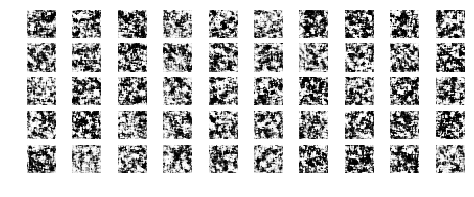

Epoch:  200


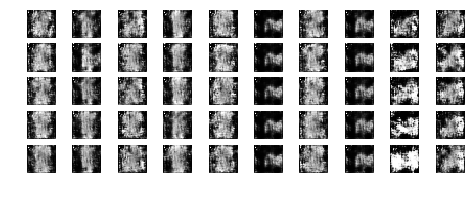

Epoch:  400


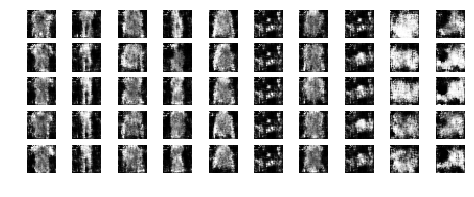

Epoch:  600


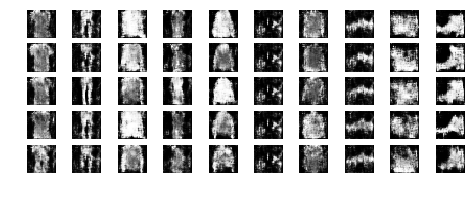

Epoch:  800


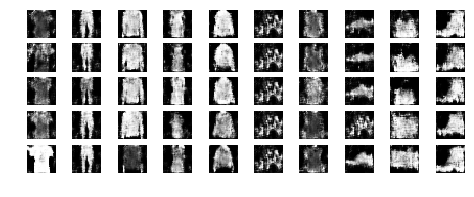

Epoch:  1000


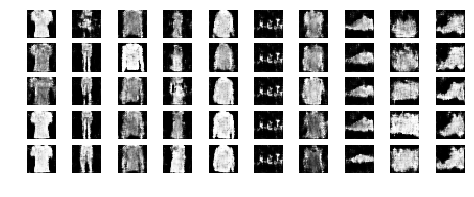

Epoch:  1200


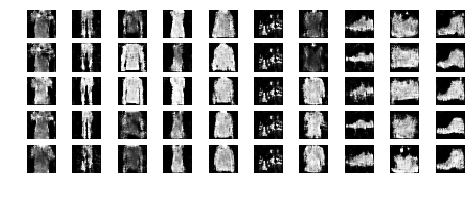

Epoch:  1400


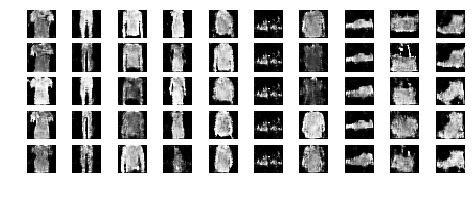

Epoch:  1600


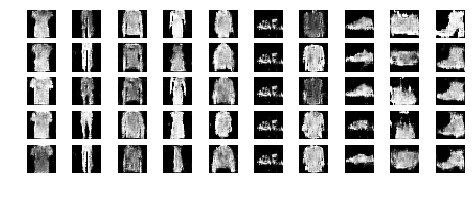

Epoch:  1800


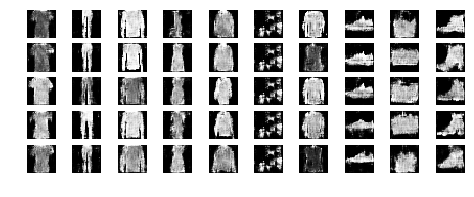

In [28]:
batch_size = 64
epochs = 2000
x_train = (x_train.astype(np.float32) - 127.5) / 127.5
y_train = y_train.reshape(-1, 1)
x_train = np.expand_dims(x_train, axis=3)

valid = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))


for epoch in range(epochs):
    idx = np.random.randint(0, x_train.shape[0], batch_size)
    imgs = x_train[idx]

    noise = np.random.normal(0, 1, (batch_size, 100))
    sampled_labels = np.random.randint(0, 10, (batch_size, 1))
    gen_imgs = generator.predict([noise, sampled_labels])

    img_labels = y_train[idx]
    fake_labels = 10 * np.ones(img_labels.shape)

    d_loss_real = discriminator.train_on_batch(imgs, [valid, img_labels])
    d_loss_fake = discriminator.train_on_batch(gen_imgs, [fake, fake_labels])
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)


    g_loss = combined.train_on_batch([noise, sampled_labels], [valid, sampled_labels])
    
    if epoch % 200 == 0:
        print ("Epoch: ",epoch)
        r, c = 5,10
        noise = np.random.normal(0, 1, (r * c, 100))
        sampled_labels = np.array([num for _ in range(r) for num in range(c)])
        gen_imgs = generator.predict([noise, sampled_labels])
        
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c, figsize=(8,3))
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt,:,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        plt.show()

In [78]:
#Generate 10000 images
r, c = 5,10
noise = np.random.normal(0, 1, (r * c, 100))
sampled_labels = np.array([num for _ in range(r) for num in range(c)])
gen_imgs = generator.predict([noise, sampled_labels])

gen_imgs = 0.5 * gen_imgs + 0.5
#print(gen_imgs.shape)
for i in range (199):
    if (i%50 == 0) :
        print(i)
    r, c = 5,10
    noise = np.random.normal(0, 1, (r * c, 100))
    sampled_labels_new = np.array([num for _ in range(r) for num in range(c)])
    new_imgs = generator.predict([noise, sampled_labels_new])
    #print(new_imgs.shape)
    
    new_imgs = 0.5 * new_imgs + 0.5

    
    gen_imgs = np.append([gen_imgs],[new_imgs], axis=1)
    gen_imgs = np.squeeze(gen_imgs, axis=0)
    #print(gen_imgs.shape)
    sampled_labels = np.append([sampled_labels],[sampled_labels_new], axis=1)
    sampled_labels = np.squeeze(sampled_labels, axis=0)
    

0
50
100
150


In [79]:
gen_imgs.shape

(10000, 28, 28, 1)

In [80]:
#Convert shape to (10000,784)
gen_imgs = np.squeeze(gen_imgs)
gen_imgs = np.reshape(gen_imgs, (gen_imgs.shape[0],gen_imgs.shape[1]*gen_imgs.shape[2] ))

In [81]:
#Column headings for files
headings = []
for i in range (1, 785):
    headings.append("Pixel"+str(i))

In [83]:
#COnvert to dataframe and write to file
dataset = pd.DataFrame(data = gen_imgs, columns= headings)
labels = pd.DataFrame(data = sampled_labels, columns= ["label"])
final_GAN = labels.join(dataset)
final_GAN.to_csv("Gan_output.csv", index = False)

In [84]:
from keras.models import load_model
combined.save('combined.h5')
discriminator.save('discriminator.h5')